## Analizador Bioimagenes C. elegans - Conteo diferencial de núcleos fluorescentes

### 1 - Instalar librerias necesarias:

In [ ]:
!pip install bioio 
!pip install bioio_bioformats 
!pip install opencv-python
!pip install matplotlib

### 2 - Importar librerias necesarias 

In [3]:
from bioio import BioImage 
import bioio_bioformats
import numpy as np  
import cv2 
import matplotlib.pyplot as plt
from enum import Enum

### 3 - Ejecutar las Clases Necesarias:

In [50]:
class BioImagenDim(Enum):
    _2D = 2
    _3D = 3
    _4D = 4
    _5D = 5
        
class BioImageHandler():
    '''
        Clase para la manipulación y procesamiento de imagenes biológicas de microscopía, en particular, confocal de fluorescencia.
        La imagen según su formato es convertida a una matriz de tipo compatible según escala de grises. Los analisis se realizan particularmente en tipo uint8.
        Se requiere Java para el empleo de bioio_bioformats. 
    '''
    
    def __init__(self, rutaImagen):
        self.rutaImagen = rutaImagen # Nota , algunos formatos pueden requerir tener sus metadatos en la propia carpeta con el mismo nombre.
        self.img = None # Array uni o multidimensional.
        self.imgArrays = None 
        self.imgMatrizActual = None
    
    def leerBioImage_CV2(self):
        # Función para imagenes 2D tipo .png, .jpg y algunos .tiff
        try:
            img = cv2.imread(self.rutaImagen, cv2.IMREAD_GRAYSCALE)
            self.img = img
            return img
        except Exception as e:
            print(f"Error al leer la imagen: {e}")
            return None   
    
    def leerBioImagen_bioformats(self):
        # Funcion que transforma una iamgen cargada por su ruta en su Array multidimensional según si es una pila de imagenes o no. 
        
        try:
            img = BioImage(self.rutaImagen, reader=bioio_bioformats.Reader)
            self.img = img.data
            return img.data
        except Exception as e:
            print(f"Error al leer la imagen: {e}")
            return None
    
    def tipoArrayImagen(self, img = None):
        # Indica el tipo de int del Array que conforma a la imagen
        
        if img is None:
            img = self.img
        
        return type(img) 
    
    def procesar_shape(self, img = None):
        """
            Función para comprobar el shape de una imagen y desempaquetar la tupla adecuadamente.
    
            Argumentos:
            img -- El array de imagen (puede ser de 2D, 3D, o 4D)
    
            Retorna:
            Un diccionario con las dimensiones de la imagen procesada (alto, ancho, canales, cortes_z, fotogramas, etc.)
            
            # Por ejemplo, el formato .ids/.ics contiene 4 imagenes según el canal, de modo que el shape del array es, por ejemplo, (1, 4, 1, 1024, 1024)
            # El primer 1 indica número de pilas de imágenes (o "z-stack"), es deciar, hay una sola imagen por canal, no un conjunto de imágenes apiladas en el eje Z.
            # El 4 , indica la cantidad de canales que son equivalentes a imagenes por canal. 
            # El tercer 1 indica la cantidad de capturadas por canal. 
            # Los 1024 indica la resolución. 
        """
    
        # Obtener el shape de la imagen
        if img is None:
            img = self.img
        
        shape = img.shape
        print(f"Shape de la imagen: {shape}")
        
        # Definir las funciones que manejan cada tipo de shape
        def procesar_2d(shape):
            # Imagen 2D (escala de grises)
            alto, ancho = shape
            return {'alto': alto, 'ancho': ancho, 'canales': 1, 'cortes_z': 1, 'fotogramas': 1}

        def procesar_3d(shape):
            # Imagen 3D (con canales o apilamiento Z)
            alto, ancho, canales = shape
            return {'alto': alto, 'ancho': ancho, 'canales': canales, 'cortes_z': 1, 'fotogramas': 1}
        
        def procesar_3d_grayscale(shape):
            # Imagen en escala de grises con una dimensión extra (ej. un fotograma)
            alto, ancho, _ = shape
            return {'alto': alto, 'ancho': ancho, 'canales': 1, 'cortes_z': 1, 'fotogramas': 1}
        
        def procesar_4d(shape):
            # Imagen 4D (por ejemplo, stack de imágenes o apilamiento con canales)
            cortes_z, canales, alto, ancho = shape
            return {'cortes_z': cortes_z, 'canales': canales, 'alto': alto, 'ancho': ancho, 'fotogramas': 1}
        
        def procesar_5d(shape):
            # Imagen 5D (stack 3D + canales + fotogramas)
            cortes_z, canales, fotogramas, alto, ancho = shape
            return {'cortes_z': cortes_z, 'canales': canales, 'fotogramas': fotogramas, 'alto': alto, 'ancho': ancho}
        
        # Diccionario simulando el "switch case"
        switch = {
            2: procesar_2d,
            3: procesar_3d,
            4: procesar_4d,
            5: procesar_5d
        }

        # Comprobar el número de dimensiones (len(shape))
        if len(shape) == 3 and shape[2] == 1:
            # Si la imagen es 3D pero con un solo canal (escala de grises)
            return procesar_3d_grayscale(shape)
        
        # Si el número de dimensiones está en el diccionario, usamos la función correspondiente
        if len(shape) in switch:
            return switch[len(shape)](shape)
        else:
            # Si no hay función definida para el número de dimensiones, devolver error
            return {'error': 'Dimensiones no soportadas'}
    
    def obtenerImagenesArray(self, img = None):
        # Recibe un tipo Array multidimensional y lo desarma en una lista de Arrays de facil acceso por índice. 
        # Suelen corresponder a los canales del microscopio 
        # Retorna el puntero a dichos arrays y el tipo del mismo.
        
        if img is None:
            img = self.img
        
        imgArrays = img.squeeze() 
        self.imagenesCanales = imgArrays 
        
        return imgArrays, imgArrays.shape 
    
    def convertirImgArray_AMAtriz(self, imgArray):
        # Convierte un array de una imagen de tipo uintx a una matriz del mismo tipo
        
        matriz_imagen = np.array(imgArray)
        max_value = np.iinfo(matriz_imagen.dtype).max
        if matriz_imagen[0, :].all() == max_value:
            matriz_imagen = matriz_imagen[1:, :]
        elif matriz_imagen[0, :].all() == np.max(matriz_imagen):
            matriz:imagen = matriz_imagen[1:, :]
        self.imgMatrizActual = matriz_imagen
        
        return matriz_imagen
    
    def normalizarImgMatriz(self, imgMatriz = None):
        # Normaliza una matriz que representa una imagen. 
        # Nota: Actualiza la matriz guardada en la clase
        
        if imgMatriz is None:
            imgMatriz = self.imgMatrizActual
        
        imgMatriz_min = np.min(imgMatriz)
        imgMatriz_max = np.max(imgMatriz)

        # Asegurarse de que no haya división por cero
        if imgMatriz_max == imgMatriz_min:
            raise ValueError("La matriz tiene todos los valores iguales. No se puede normalizar.")
    
        # Normalizar los valores al rango [0, 1] basado en el rango real de los datos
        matriz_img_norm = (imgMatriz - imgMatriz_min) / (imgMatriz_max - imgMatriz_min)
        self.imgMatrizActual = matriz_img_norm
        
        return matriz_img_norm
    
    def binarizarImgMatrizNorm(self, imgMatriz = None, threshold = 0.5):
        # Dada una matriz normalizada , la binariza (transforma a 0 y 1) dado cierto threshold para la señal. 
        
        if imgMatriz is None:
            imgMatriz = self.imgMatrizActual
        
        imgBinMatriz = imgMatriz
        imgBinMatriz[imgMatriz > threshold] = 1
        imgBinMatriz[imgMatriz <= threshold] = 0
        imgBinMatriz = imgBinMatriz.astype(np.uint8)
        self.imgMatrizActual = imgBinMatriz
        
        return imgBinMatriz

In [51]:
class RastreadorGusanos(BioImageHandler):
    '''
        A partir de una bioimagen de un canal de fluorescencia de nucleos:
        - Detección y rotulo de los nucleos.
        - Obtención de un diccionario de tuplas (x,y) de sus coordenadas.
        - Determinación de su centroide.
        - Grafico comparativo de recuadros encerrando el núcleo y del centroide
        - Estadística de la fluorescencia de los nucleos en Unidades Arbitrarias de Fluorescencia.
    '''
    
    def __init__(self, rutaImagen, canalActual = None):
        super().__init__(rutaImagen) # Para herencia de BioImageHandler
        self.canalActual = canalActual
        self.imgActual = None
        self.imgProcesada = None
        self.num_nucleos = None # Nota: Se debe restar 1 a este valor, puesto que cuenta al fondo como rotulo 0. 
        self.imgRotulada = None
        self.centroides = None 
        self.coordenadasNucleos = None
        
    def procesarImagen(self, tipo = BioImagenDim._2D, canal = 0, threshold = 0.5):
        '''
            Recibe un indice a un array de un array multidimensional de imagen. Por Default es 0.
            Si la imagen es un unico array,se devuelve la misma.
            Devuelve la imagen como tipo de bioio y la misma procesada a matriz binaria.
        '''
        
        if tipo == BioImagenDim._2D:
            img = super().leerBioImage_CV2()
        else:
            img = super().leerBioImagen_bioformats()   
        
        if img is None:
            print("No image loaded")
            return None, None
    
        # Process the image shape
        forma_imagen = super().procesar_shape(img)
        
        # Check if the image has multiple channels, and extract the channel if needed
        if forma_imagen['canales'] > 1:  # If not a 2D or 3D single-channel image
            imgArrays, _ = super().obtenerImagenesArray(img)
            img = imgArrays[canal]
        
        self.imgActual = img
        
        # Process the image: convert to matrix, normalize, binarize
        imgProcesada = super().convertirImgArray_AMAtriz(img)
        imgProcesada = super().normalizarImgMatriz(imgProcesada)
        imgProcesada = super().binarizarImgMatrizNorm(imgProcesada, threshold)
        self.imgProcesada = imgProcesada
        
        return img, imgProcesada
    
    def buscarNucleos(self, imgBinaria = None, tol_cerrada = 5, tol_abierta = 5):
        '''
            Toma una imagen binarizada de un canal de fluorescencia donde hay emisión desde nucleos y la procesa
            para rotular los grupos de pixeles correspondientes a cada nucleo. Realiza la siguientes operaciones:
            - Cierre morfológico : Une los huecos pequeños (tolerancia)
            - Apertura morfológica : elimina los objetos muy pequeños (Filtrado por tamaño)
            - Detectar componentes finales
        '''
        if imgBinaria is None:
            imgBinaria = self.imgProcesada
        
        # 1 - Cierre morfológico
        kernel_cerrado = np.ones((tol_cerrada, tol_cerrada), np.uint8)  # tamaño del kernel = tolerancia a ceros internos
        matriz_bin_cerrada = cv2.morphologyEx(imgBinaria, cv2.MORPH_CLOSE, kernel_cerrado)
        
        # 2 - Apertura morfológica 
        kernel_abierto = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (tol_abierta, tol_abierta))
        mascara_filtrada = cv2.morphologyEx(matriz_bin_cerrada, cv2.MORPH_OPEN, kernel_abierto)
        
        # 3 - Detectar nucleos
        num_nucleos_filtrados, nucleos_filtrados = cv2.connectedComponents(mascara_filtrada, connectivity=8)
        self.num_nucleos = num_nucleos_filtrados
        self.imgRotulada = nucleos_filtrados
        
        return num_nucleos_filtrados, nucleos_filtrados
    
    def centroidesNucleos(self, num_nucleos = None, nucleos_filtrados = None):
        
        if num_nucleos is None:
            num_nucleos = self.num_nucleos
        if nucleos_filtrados is None:
            nucleos_filtrados = self.imgRotulada
        
        centroides = {}
        for nucleo in range(1, num_nucleos):
            coordenadas = np.column_stack(np.where(nucleos_filtrados == nucleo))
            centroide = coordenadas.mean(axis=0)
            centroides[f"nucleo_{nucleo}"] = (int(centroide[0]), int(centroide[1]))
        
        self.centroides = centroides
        
        return centroides
    
    def coordenadasDeNucleos(self, num_nucleos = None, nucleos_filtrados = None):
        
        if num_nucleos is None:
            num_nucleos = self.num_nucleos
        if nucleos_filtrados is None:
            nucleos_filtrados = self.imgRotulada
        
        coordenadasNucleos = {}
        for nucleo in range(1, num_nucleos):
            coordenadas = np.column_stack(np.where(nucleos_filtrados == nucleo))
            coordenadasNucleos[f"nucleo_{nucleo}"] = coordenadas.tolist()
        
        self.coordenadasNucleos = coordenadasNucleos
        
        return coordenadasNucleos
    
    def graficarNucleosRastreados(self, imgOriginal = None, coordenadasNucleos = None, coordenadasCentroides = None, titulo = None,
                                  centroideON = True, rectanguloON = True, rotulosON = True, colorRotulo = 'blue'):
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        if imgOriginal is None:
            imgOriginal = self.imgActual
        if coordenadasCentroides is None:
            coordenadasCentroides = self.centroides
        if coordenadasNucleos is None:
            coordenadasNucleos = self.coordenadasNucleos
        if titulo is None:
            titulo = "Imagen original"

        # Subplot izquierdo: imagen original
        axes[0].imshow(imgOriginal, cmap='gray')
        axes[0].set_title(titulo)
        axes[0].axis('off')

        # Subplot derecho: con rectángulos y centroides
        axes[1].imshow(imgOriginal, cmap='gray')

        # Access num_nucleos and nucleos_filtrados
        num_nucleos = self.num_nucleos
        nucleos_filtrados = self.imgRotulada

        for nucleo in range(1, num_nucleos):
            # Get coordinates of the nucleus
            coordenadas = np.column_stack(np.where(nucleos_filtrados == nucleo))
            min_fila, min_columna = coordenadas.min(axis=0)
            max_fila, max_columna = coordenadas.max(axis=0)

            # Dibujar rectángulo
            rectangulo = plt.Rectangle((min_columna - 1, min_fila - 1),
                                    max_columna - min_columna + 2, max_fila - min_fila + 2,
                                    edgecolor='red', facecolor='none', linewidth=1)
            
            if rectanguloON:
                axes[1].add_patch(rectangulo)

            # Dibujar centroide (más pequeño con markersize=4)
            centroide_fila, centroide_columna = coordenadasCentroides[f"nucleo_{nucleo}"]

            if centroideON:
                axes[1].plot(centroide_columna, centroide_fila, 'gx', markersize=4)

            # Etiqueta cerca del centroide
            if rotulosON:
                axes[1].text(centroide_columna + 20, centroide_fila + 1, f"nucleo_{nucleo}", color=colorRotulo, fontsize=8)

        axes[1].set_title("Nucleos detectados y delimitados")
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()

### 4 - Ejemplo de Uso

##### Ruta del archivo:

In [10]:
ruta_base = "/home/nephelim/Documentos/Investigacion/BioPictureTools/SetImagenes_1/"
ruta_prueba_1 = ruta_base + "RADSMAD ztf30 1.ids"
ruta_prueba_2 = ruta_base + "example.png"

#### Ejecución de prueba 

Nota: Los errores de Java son por parseo de los metadatos de los archivos de imagen.

15:11:44.078 [main] INFO loci.formats.ImageReader - ICSReader initializing /home/nephelim/Documentos/Investigacion/BioPictureTools/SetImagenes_1/RADSMAD ztf30 1.ids
15:11:44.078 [main] DEBUG loci.formats.FormatHandler - ICSReader initializing /home/nephelim/Documentos/Investigacion/BioPictureTools/SetImagenes_1/RADSMAD ztf30 1.ids
15:11:44.078 [main] DEBUG loci.formats.FormatHandler - loci.formats.in.ICSReader.initFile(/home/nephelim/Documentos/Investigacion/BioPictureTools/SetImagenes_1/RADSMAD ztf30 1.ids)
15:11:44.078 [main] INFO loci.formats.FormatHandler - Finding companion file
15:11:44.079 [main] INFO loci.formats.FormatHandler - Checking file version
15:11:44.080 [main] INFO loci.formats.FormatHandler - Reading metadata
15:11:44.122 [main] DEBUG loci.formats.FormatHandler - Could not parse double value 'Confocal C1 Scanner'
java.lang.NumberFormatException: For input string: "Confocal C1 Scanner"
	at java.base/jdk.internal.math.FloatingDecimal.readJavaFormatString(Unknown Source

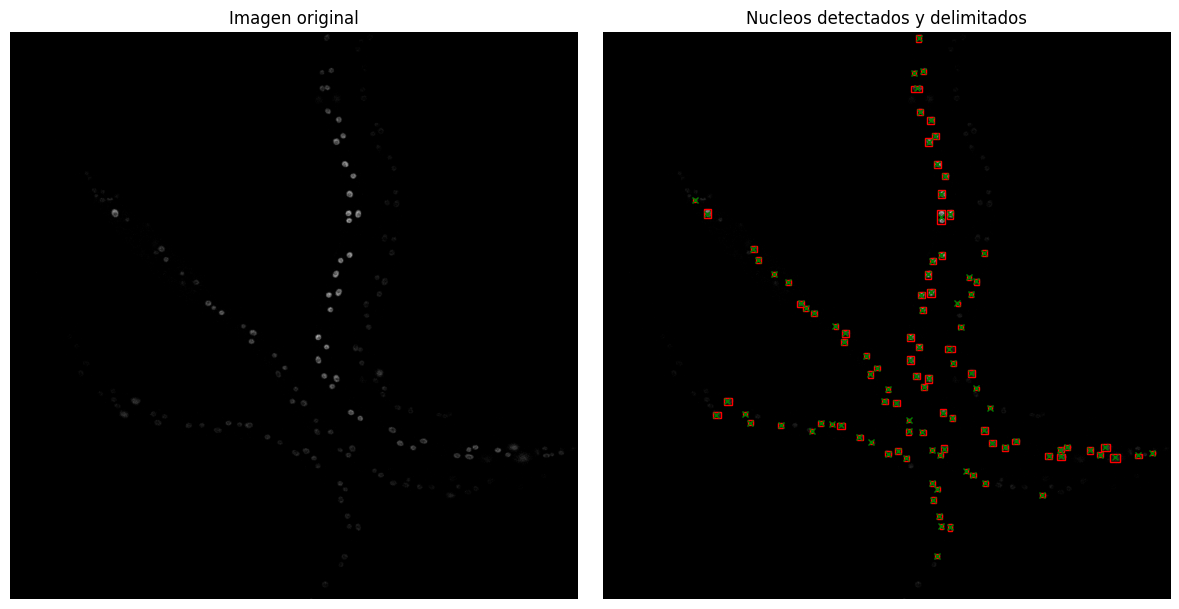

In [56]:
nuevoRastreador = RastreadorGusanos(ruta_prueba_1)
nuevoRastreador.procesarImagen(tipo=BioImagenDim._3D, canal=1, threshold=0.1)
nuevoRastreador.buscarNucleos(tol_cerrada = 5, tol_abierta = 5)
nuevoRastreador.centroidesNucleos()
nuevoRastreador.coordenadasDeNucleos()
nuevoRastreador.graficarNucleosRastreados(rotulosON=False)

In [21]:
nuevoRastreador = RastreadorGusanos(ruta_prueba_1)
nuevoRastreador.procesarImagen(tipo=BioImagenDim._3D, canal=3, threshold=0.9)
nuevoRastreador.buscarGusanos(min_pixeles_seguidos=10, off_set=100)
nuevoRastreador.centroidesNucleos()
nuevoRastreador.coordenadasDeNucleos()
nuevoRastreador.graficarNucleosRastreados(rotulosON=False)

14:43:12.372 [main] INFO loci.formats.ImageReader - ICSReader initializing /home/nephelim/Documentos/Investigacion/BioPictureTools/SetImagenes_1/RADSMAD ztf30 1.ids
14:43:12.372 [main] DEBUG loci.formats.FormatHandler - ICSReader initializing /home/nephelim/Documentos/Investigacion/BioPictureTools/SetImagenes_1/RADSMAD ztf30 1.ids
14:43:12.372 [main] DEBUG loci.formats.FormatHandler - loci.formats.in.ICSReader.initFile(/home/nephelim/Documentos/Investigacion/BioPictureTools/SetImagenes_1/RADSMAD ztf30 1.ids)
14:43:12.372 [main] INFO loci.formats.FormatHandler - Finding companion file
14:43:12.372 [main] INFO loci.formats.FormatHandler - Checking file version
14:43:12.373 [main] INFO loci.formats.FormatHandler - Reading metadata
14:43:12.398 [main] DEBUG loci.formats.FormatHandler - Could not parse double value 'Confocal C1 Scanner'
java.lang.NumberFormatException: For input string: "Confocal C1 Scanner"
	at java.base/jdk.internal.math.FloatingDecimal.readJavaFormatString(Unknown Source

KeyboardInterrupt: 

Shape de la imagen: (514, 714)


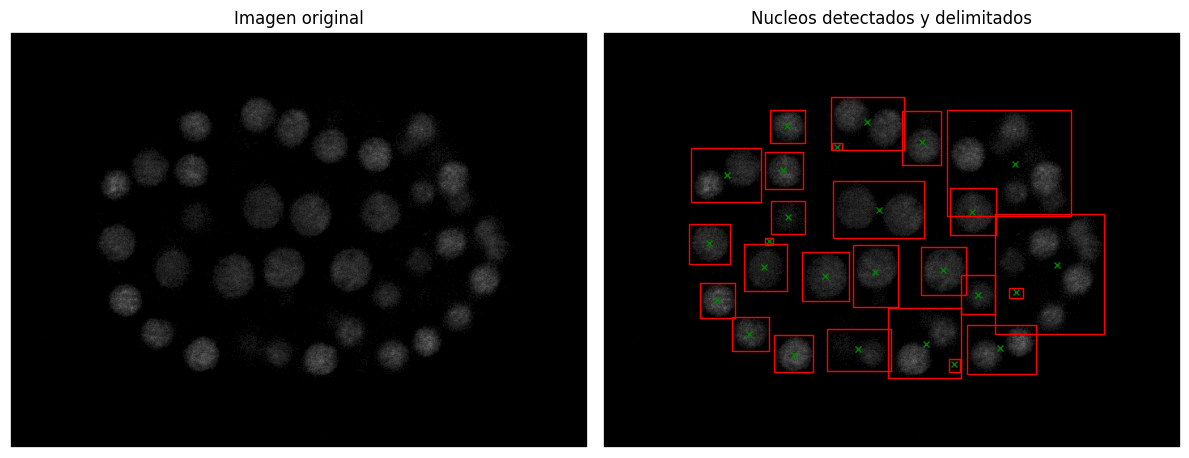

In [24]:
nuevoRastreador = RastreadorGusanos(ruta_prueba_2)
nuevoRastreador.procesarImagen(canal=1, threshold=0.97)
nuevoRastreador.buscarNucleos(tol_cerrada = 5, tol_abierta = 5)
nuevoRastreador.centroidesNucleos()
nuevoRastreador.coordenadasDeNucleos()
nuevoRastreador.graficarNucleosRastreados(rotulosON=False)